# INTRODUCTION

In [9]:
# TODO:ADD INTRO HERE

# IMPORTATION

In [10]:
# Import necessary libraries

# Connect to server
import pyodbc
from dotenv import dotenv_values

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px

# Visualize missing values
import missingno as msno

# Machine Learning
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import warnings

# ignore warnings
warnings.filterwarnings('ignore')

# DATA LOADING

Create a .env file in root of the folder of the project and all the sensitive information in the .env file

In [11]:
# Load environment variables from a .env file
env_variables = dotenv_values('.env')

server= env_variables.get('SERVER')
database= env_variables.get('DATABASE')
username= env_variables.get('USERNAME')
password= env_variables.get('PASSWORD')

Create a .gitignore file and type '/.env/' file we just created. This will prevent git from tracking the file.

Create a connection by accessing your connection string with your defined environment variables 

In [12]:
# Setup connection string to connect to the remote server
connection_string = pyodbc.connect(f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}')

Setup the links and queries to read the data from the various sources

In [13]:
# Query statement to fetch the first 3000 data from the remote server
telco_churn_3000_query = 'SELECT * FROM dbo.LP2_Telco_churn_first_3000'

# Get link to the third data hosted on github
telco_churn_last2000_url = "https://raw.githubusercontent.com/Azubi-Africa/Career_Accelerator_LP2-Classifcation/main/LP2_Telco-churn-last-2000.csv"

In [14]:
# Read all data from different sources
df_first_3000 = pd.read_sql_query(telco_churn_3000_query, connection_string)
df_second_2000 = pd.read_excel('Telco-churn-second-2000.xlsx')
df_last_2000 = pd.read_csv(telco_churn_last2000_url)

# EXPLORATORY DATA ANALYSIS (EDA)

Use various pandas methods to get preliminary information about the various datasets

In [80]:
# View the 5 first rows of the first 3000 data points
df_first_3000.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [81]:
# View the first 5 rows of the second 2000 data points
df_second_2000.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


In [82]:
# View the first 5 rows of the last 2000 data points
df_last_2000.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [83]:
# Check the number of columns and rows in each data
df_first_3000.shape, df_second_2000.shape, df_last_2000.shape

((3000, 21), (2000, 20), (2043, 21))

In [84]:
# Get more information about the columns and their data types

df_first_3000.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [85]:
# second dataset
df_second_2000.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


In [86]:
df_last_2000.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [87]:
# Check for duplicated rows if any in the first 3000 data points
df_first_3000.duplicated().sum()

0

In [88]:
# Check for duplicated rows if any in the second 2000 data points
df_second_2000.duplicated().sum()

0

In [89]:
# Check for duplicated rows if any in the last 2000 data points
df_last_2000.duplicated().sum()

0

In [94]:
# Define a function to check for the number of unique values in categorical columns
def check_unique_values(df):
    """
    Check the number of unique values in the categorical columns in the DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.

    Returns:
        None
    """
    print("Checking unique values in categorical columns:")

    # Iterate through each column
    for col in df.columns:
        # Check if the column is categorical (object type) and not the 'customerID' column
        if (df[col].dtype == 'object') and (col != 'customerID'):
            # Print the column name and its unique values
            print(col, '---->', df[col].unique())

In [95]:
# Call the function to check unique values for the first 3000 dataFrame
check_unique_values(df_first_3000)

Checking unique values in categorical columns:
gender ----> ['Female' 'Male']
MultipleLines ----> [None False True]
InternetService ----> ['DSL' 'Fiber optic' 'No']
OnlineSecurity ----> [False True None]
OnlineBackup ----> [True False None]
DeviceProtection ----> [False True None]
TechSupport ----> [False True None]
StreamingTV ----> [False True None]
StreamingMovies ----> [False True None]
Contract ----> ['Month-to-month' 'One year' 'Two year']
PaymentMethod ----> ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn ----> [False True None]


In [96]:
# Call the function to check unique values for the second 2000 dataFrame
check_unique_values(df_second_2000)

Checking unique values in categorical columns:
gender ----> ['Male' 'Female']
Partner ----> ['No' 'Yes']
Dependents ----> ['No' 'Yes']
PhoneService ----> ['Yes' 'No']
MultipleLines ----> ['Yes' 'No' 'No phone service']
InternetService ----> ['Fiber optic' 'No' 'DSL']
OnlineSecurity ----> ['No' 'No internet service' 'Yes']
OnlineBackup ----> ['No' 'No internet service' 'Yes']
DeviceProtection ----> ['No' 'No internet service' 'Yes']
TechSupport ----> ['No' 'No internet service' 'Yes']
StreamingTV ----> ['Yes' 'No internet service' 'No']
StreamingMovies ----> ['No' 'No internet service' 'Yes']
Contract ----> ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ----> ['Yes' 'No']
PaymentMethod ----> ['Electronic check' 'Mailed check' 'Credit card (automatic)'
 'Bank transfer (automatic)']
TotalCharges ----> [1059.55 181.8 2212.55 ... 552.95 7053.35 301.55]


In [97]:
# Call the function to check unique values for the last 2000 dataFrame
check_unique_values(df_last_2000)

Checking unique values in categorical columns:
gender ----> ['Male' 'Female']
Partner ----> ['No' 'Yes']
Dependents ----> ['No' 'Yes']
PhoneService ----> ['Yes' 'No']
MultipleLines ----> ['No' 'No phone service' 'Yes']
InternetService ----> ['DSL' 'Fiber optic' 'No']
OnlineSecurity ----> ['No' 'Yes' 'No internet service']
OnlineBackup ----> ['No' 'Yes' 'No internet service']
DeviceProtection ----> ['No' 'Yes' 'No internet service']
TechSupport ----> ['Yes' 'No' 'No internet service']
StreamingTV ----> ['No' 'Yes' 'No internet service']
StreamingMovies ----> ['No' 'Yes' 'No internet service']
Contract ----> ['Month-to-month' 'Two year' 'One year']
PaperlessBilling ----> ['Yes' 'No']
PaymentMethod ----> ['Credit card (automatic)' 'Electronic check' 'Mailed check'
 'Bank transfer (automatic)']
TotalCharges ----> ['312.7' '1046.5' '2960.1' ... '346.45' '306.6' '6844.5']
Churn ----> ['No' 'Yes']


In [100]:
# Define a function to check and visualize missing values
def check_missing_values(df):
    """
    Check for missing values in the DataFrame and visualize it using missingno.

    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.

    Returns:
        None
    """
    # Check for missing values in the DataFrame
    missing_values = df.isnull().sum()

    print("Missing values in the DataFrame:")
    print(missing_values)

    # Visualize missing values using missingno matrix
    msno.matrix(df)

Missing values in the DataFrame:
customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64


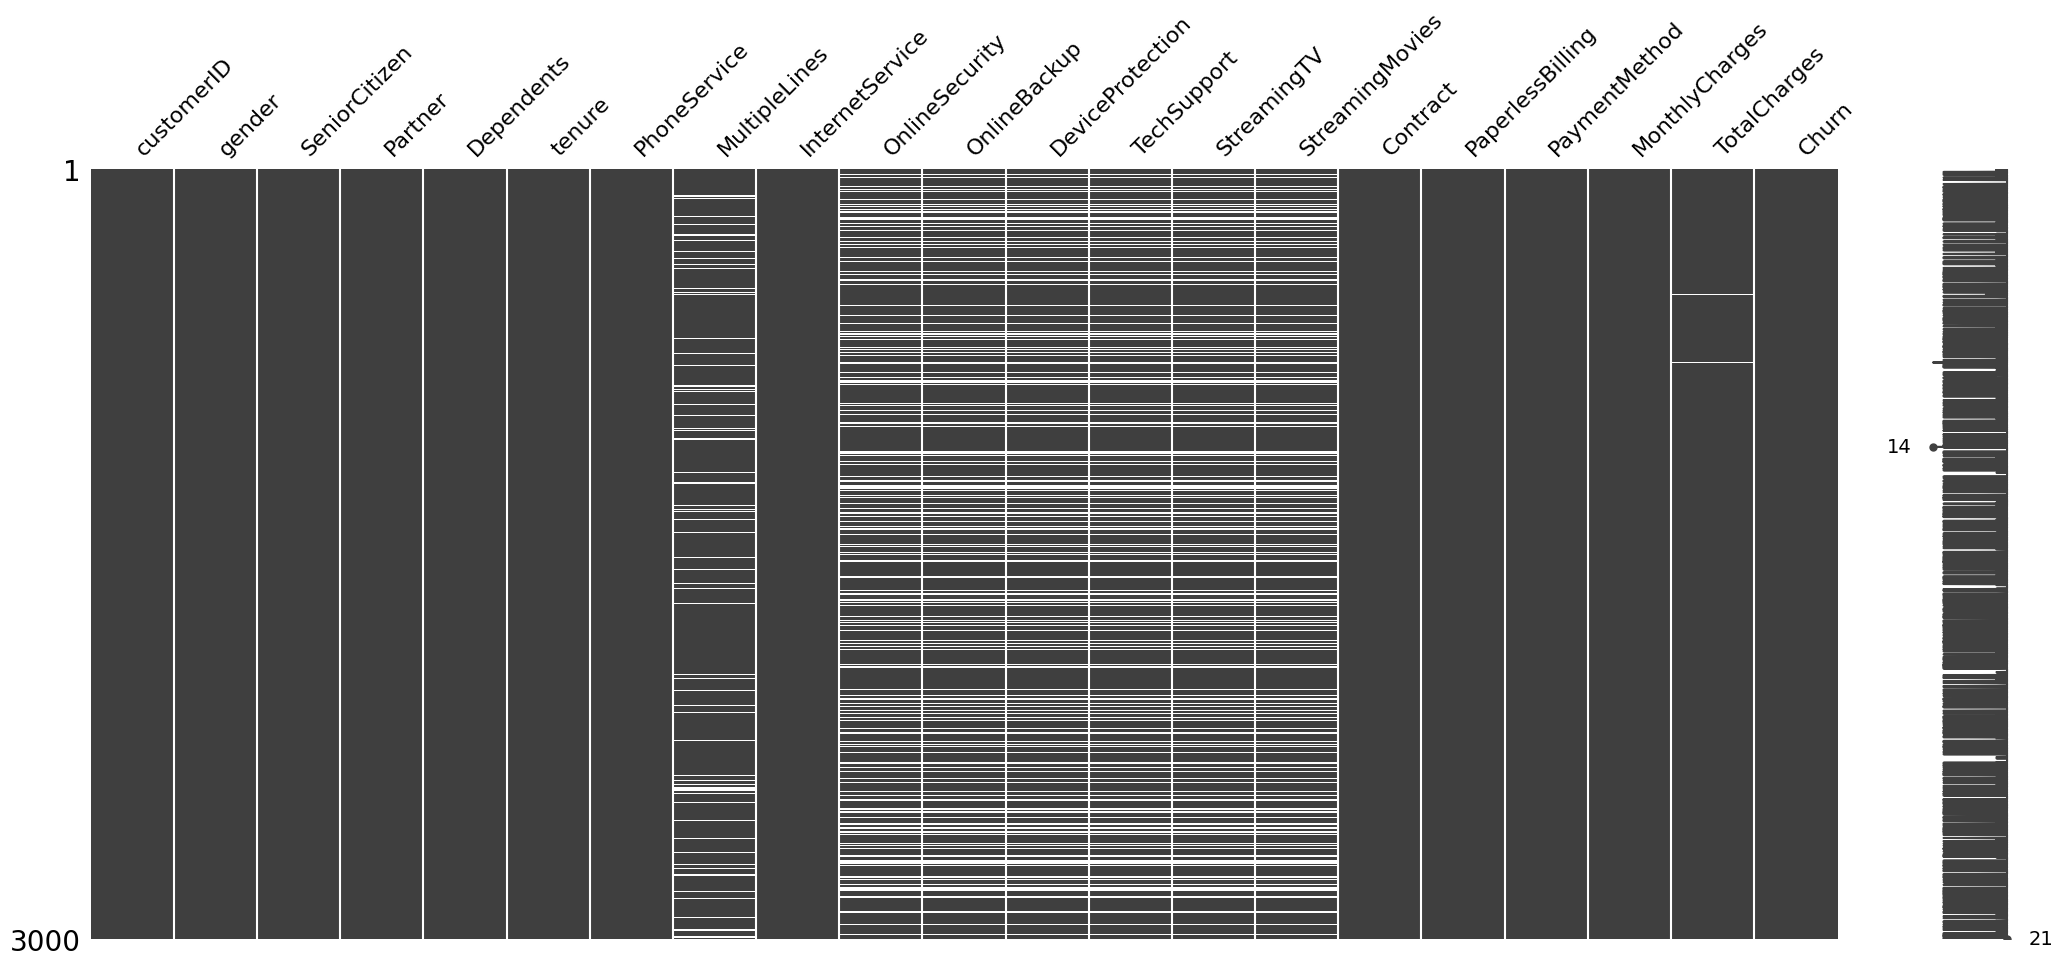

In [101]:
# Check for missing values in the first 3000 data points
check_missing_values(df_first_3000)


Missing values in the DataFrame:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


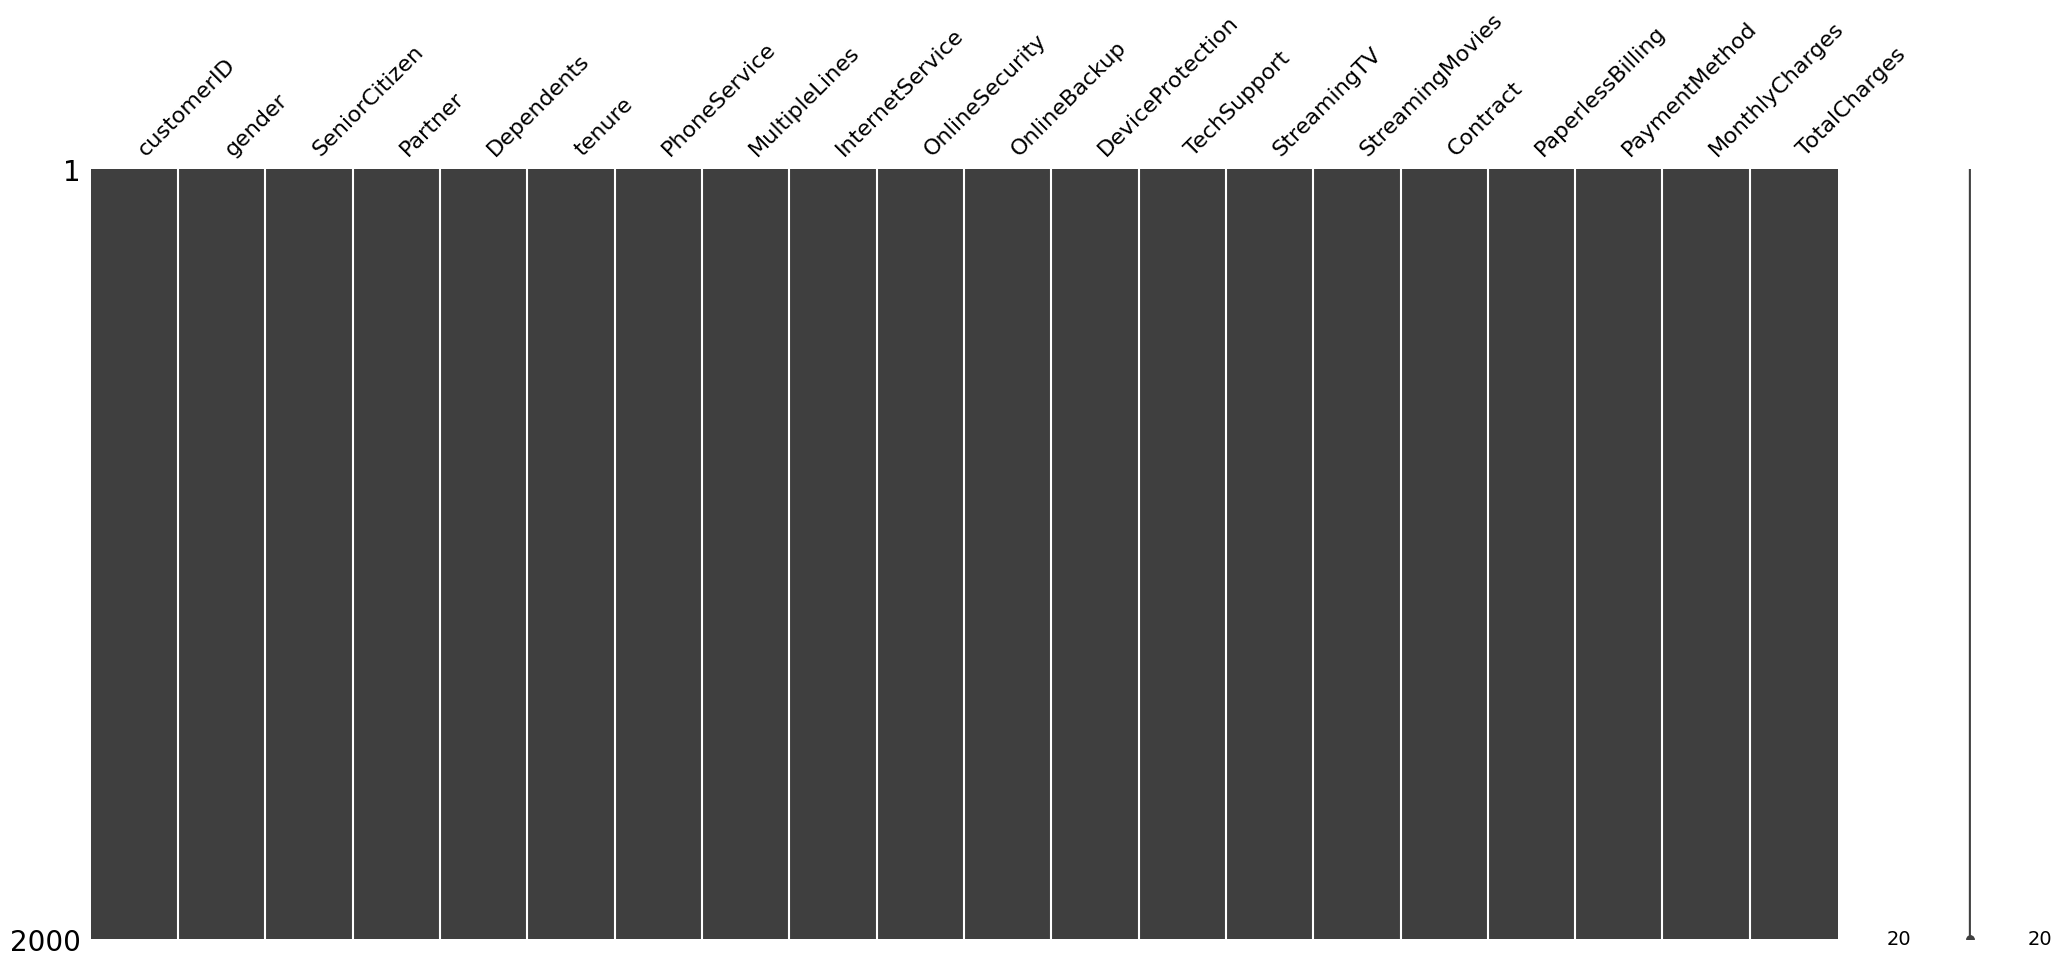

In [102]:
# Check for missing values in the second 2000 data points
check_missing_values(df_second_2000)


Missing values in the DataFrame:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


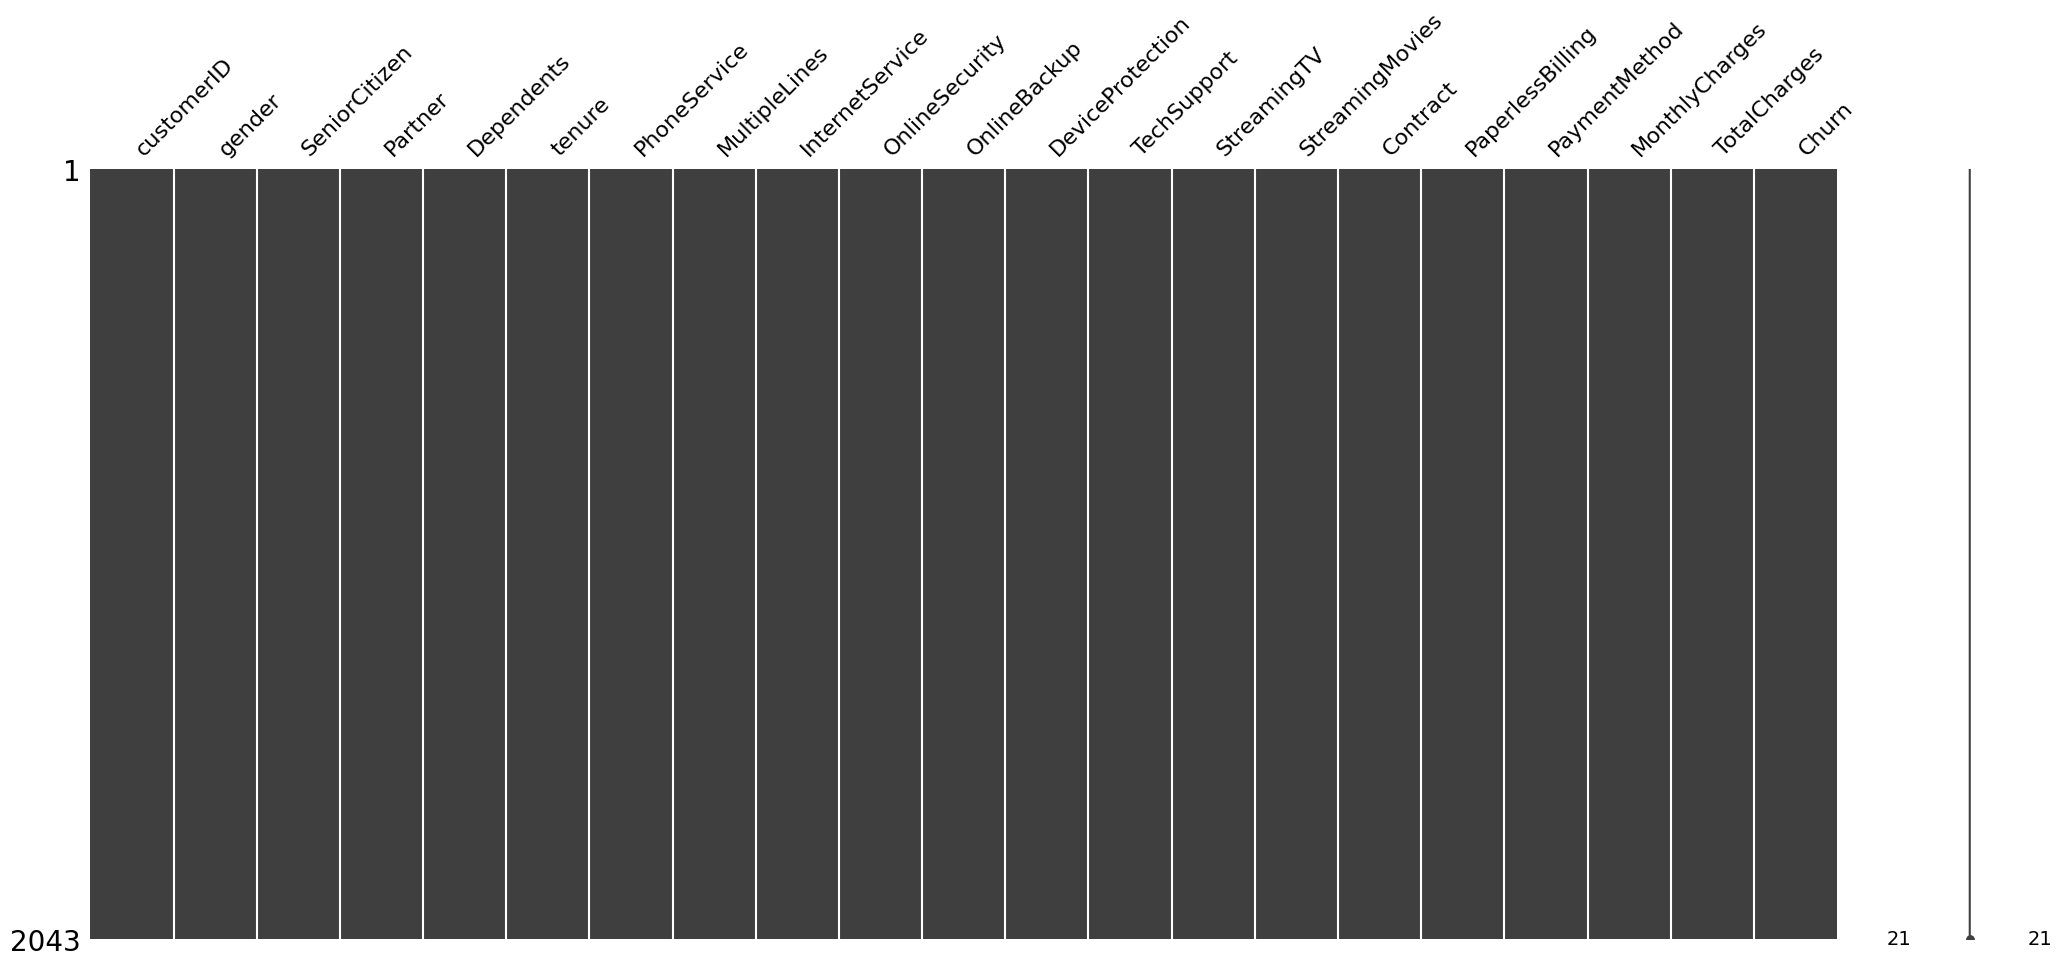

In [103]:
# Check for missing values in the last 2000 data points
check_missing_values(df_last_2000)
